# Structure of project
**This piece of code is able to run without requiring too much computating power. Please notice that there are only limited samples, the model would learn nothing, its result is different from that in project report. The results in the report are given by models trained with thoudsands of samples.**
## 1.1 ml-project_final.ipynb
## 1.2 meta info files
1. train.csv,  image_id, class_name, class_id, rad_id, x_min, y_min, x_max, y_max
1. train_meta.csv, image_id, dim0(width), dim1(height)
1. train_merged.csv, image_id, class_name, class_id, rad_id, x_min, y_min, x_max, y_max, dim_x, dim_y
1. train_set1.csv,image_id, class_id(0:normal, 1:abnormal) 
1. train_set2.csv,image_id, class_id_0,class_id_3,class_id_11,class_id_13
1. train_selected.csv, subset of train_set1.csv, contains 1024 rows
1. binary_train.csv, training dataset for binary classifier
1. binary_test.csv, test dataset for binary classifier
1. multi_label_train.csv, training dataset for multi-label classifier
1. multi_label_test.csv, test dataset for multi-label classifier

## 1.3 train, containing images for training and test 

## 1.4 concerned classes:
1. 14: no finding
1. 0: Aortic enlargement
1. 3: Cardiomegaly
1. 11: Pleural thickening
1. 13: Pulmonary fibrosis

In [2]:
import os
import math

import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import matplotlib.patches as patches
import seaborn as sns

import cv2
from sklearn.utils import shuffle
import keras
from keras.applications import ResNet50
from keras.layers import GlobalAveragePooling2D,Dense,Dropout
from keras.models import Model
from tensorflow.keras import regularizers
import pydicom

#check gpu is availabe
import tensorflow as tf
tf.test.gpu_device_name()

'/device:GPU:0'

In [4]:
#1.common functions
"""
convert a dicom file to png file
scale the file to 512x512
display the bounding box on scaled png file
"""
def read_xray(path, voi_lut = True, fix_monochrome = True):
    dicom = pydicom.read_file(path)
    # VOI LUT (if available by DICOM device) is used to transform raw DICOM data to 
    # "human-friendly" view
    if voi_lut:
        data = pydicom.pixel_data_handlers.apply_voi_lut(dicom.pixel_array, dicom)
    else:
        data = dicom.pixel_array  
    # depending on this value, X-ray may look inverted - fix that:
    if fix_monochrome and dicom.PhotometricInterpretation == "MONOCHROME1":
        data = np.amax(data) - data
    data = data - np.min(data)
    data = data / np.max(data)
    data = (data * 255).astype(np.uint8)
    return data

def disp_xray(path,bounding_box=None):
    xray_data = read_xray(path)
    fig, ax = plt.subplots()
    ax.imshow(xray_data,cmap ='gray')
    # Create a Rectangle patch
    #patches.Rectangle((x_min, y_min), width=x_max-x_min, height=y_max-y_min)
    if bounding_box != None:
        rect = patches.Rectangle((bounding_box[0], bounding_box[1]), bounding_box[2], bounding_box[3], linewidth=1, edgecolor='r', facecolor='none')
        # Add the patch to the Axes
        ax.add_patch(rect)
    plt.show()

"""
display bounding box for an image
img_meta_info = train_merged_pd[train_merged_pd["image_id"].isin([filename])]
img_meta_info = img_meta_info.sort_values(by=['class_id','rad_id'])
"""
def disp_xray_diagnosis(pngpath, row_meta_info):
    img = cv2.imread(pngpath)[:,:,0]
    img_width = img.shape[1]
    img_height = img.shape[0]
    img_num = row_meta_info.shape[0]
    plot_num_per_row = 2
    ncols=min(img_num,plot_num_per_row)
    nrows=int(np.ceil(img_num/plot_num_per_row))
    plt.subplots(nrows,ncols,figsize=(ncols*5,nrows*5))
    n = 1
    for index, row in row_meta_info.iterrows():
        ax = plt.subplot(nrows, ncols, n)
        n = n + 1
        plt.title(row[1] + " by " + row[3])
        if math.isnan(row[4]) or math.isnan(row[5]) or math.isnan(row[6]) or math.isnan(row[7]):
            print('no finding')
        else:
            #x_min: 900, y_min:580, x_max: 1200, y_max: 900, scale_factor: 512/3072
            scale_factor_x = img_width/row[8]
            scale_factor_y = img_height/row[9]
            x_min = int(row[4]*scale_factor_x)
            y_min = int(row[5]*scale_factor_y)
            x_max = int(row[6]*scale_factor_x)
            y_max = int(row[7]*scale_factor_y)
            x_max_min = x_max-x_min
            y_max_min = y_max-y_min
            #patches.Rectangle((x_min, y_min), x_max-x_min, y_max-y_min)
            rect = patches.Rectangle((x_min, y_min), x_max_min, y_max_min, linewidth=2, edgecolor='r', facecolor='none')
            ax.add_patch(rect)
        plt.imshow(img, cmap='gray')
    fig = plt.gcf()
    fig.savefig('./bounding_box.jpg')
"""
customize ResNet
"""
def customizeResNet(input_shape=(512,512,1),output_shape=1,model_path=None,include_top=False,net_type="binary"):
    if model_path is None:
        model = ResNet50(input_shape = input_shape, weights=None, classes=output_shape,include_top=include_top)
        if not include_top:
            if net_type == "binary":
                avg_pool = GlobalAveragePooling2D()(model.output)
                dropout = Dropout(0.4)(avg_pool)
                binary_output = Dense(output_shape, activation='sigmoid')(dropout)
                model = Model(inputs=model.inputs, outputs=binary_output)
                model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])
            elif net_type == "binary2":
                avg_pool = GlobalAveragePooling2D()(model.output)
                dropout1 = Dropout(0.4)(avg_pool)
                dense1 = Dense(dropout1.shape[1], activation='relu',kernel_regularizer=regularizers.l2(1e-2))(dropout1)
                dropout2 = Dropout(0.4)(dense1)
                binary_output = Dense(output_shape, activation='sigmoid',kernel_regularizer=regularizers.l2(1e-2))(dropout2)
                model = Model(inputs=model.inputs, outputs=binary_output)
                model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])
            else:
                avg_pool = GlobalAveragePooling2D()(model.output)
                dropout = Dropout(0.4)(avg_pool)
                multilabel_output = Dense(output_shape, activation='sigmoid')(dropout)
                model = Model(inputs=model.inputs, outputs=multilabel_output)
                model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])
    else:
        model = keras.models.load_model(model_path)
    return model

#function used for data preprocessing
def mergeData(src1="./train.csv", src2="./train_meta.csv",dest="./train_merged.csv", verbose=False, persist=False):
    
    src1_pd = pd.read_csv(src1)
    src2_pd = pd.read_csv(src2)
    
    row_num = src1_pd.shape[0]
    src1_pd["dim_x"] = np.zeros([row_num,1])
    src1_pd["dim_y"] = np.zeros([row_num,1])

    #merge dim info of dicom from src2 into src1
    for index, row in src1_pd.iterrows():
        meta_row = src2_pd[src2_pd["image_id"].isin([row["image_id"]])] #a match dataframe
        src1_pd.iloc[index,8] = meta_row.iloc[0,1]
        src1_pd.iloc[index,9] = meta_row.iloc[0,2]
        if verbose:
            print(index, meta_row.iloc[0,0], meta_row.iloc[0,1],meta_row.iloc[0,2])
    if persist:
        src1_pd.to_csv(dest,index=None)
    return src1_pd

def dispDist(data, grouplist=['class_name']):
    class_sample_counts=data.groupby(grouplist).size().reset_index().rename(columns={0:'count'})
    class_sample_counts.sort_values(by='count',inplace=True, ascending=False)
    class_sample_counts.reset_index(drop=True)

    plt.figure(figsize=(15,5))
    sns.set(font_scale = 1.5)
    g=sns.barplot(x=grouplist[0],y='count',data=class_sample_counts)
    g=g.set_xticklabels(g.get_xticklabels(), rotation=90)
    
"""
generate train_set1 and train_set2
1.remove rare abnormality, keep 14:no finding 0:Aortic enlargement 3:Cardiomegaly,11:Pleural thickening, 13:Pulmonary fibrosis
2.construnct train_set1, containing all images with class_id 0 normal, 1 abnormal
3.construnct train_set2, containing all abnormal images with class_in in (0,3,11,13)

"""
def genSet1andSet2(train_merged_pd, set1="./train_set1.csv", set2="./train_set2.csv", shuffle_flag = True, persist=False):
    #preserve class_id in [14,0,3,11,14]
    train_set11 = train_merged_pd[train_merged_pd.class_id.isin([14,0,3,11,13])]
    #compute the count for each (image_id,class_id), the output is 
    train_set12 = pd.DataFrame(train_set11.groupby(['image_id','class_id']).size())
    train_set13 = train_set12.reset_index().rename(columns={0:'count'})
    #preserve the count()>1, means >=2 radiologists have an consensus on the diagnosis
    train_set14 = train_set13[train_set13['count'] > 1]
    train_set15 = train_set14[train_set14.class_id.isin([14])]
    train_set16 = train_set14[train_set14.class_id.isin([0,3,11,13])]
    #get train_set1 containing class_id 0 and 1, 0: normal, 1:abnormal
    
    train_set1 = train_set15.iloc[:,0:2]
    train_set1['class_id'] = train_set1['class_id'].apply(lambda v:0)
    train_set17 = train_set16.drop(axis=1,labels=['count']).drop_duplicates(['image_id'])
    train_set17['class_id'] = train_set17['class_id'].apply(lambda v:1)
    train_set1 = pd.concat([train_set1,train_set17])
    train_set1.reset_index(drop=True,inplace=True)
    
    #get train_set2, convert class_id to categorical columns
    train_set18 = train_set16.drop(axis=1,labels=['count'])
    train_set18.head()
    train_set2 = pd.DataFrame(columns=['image_id','0','3','11','13'])
    #0,3,11,13 mapping to 1,2,3,4
    index_mapping = {0:1,3:2,11:3,13:4}
    for index,row in train_set18.iterrows():
        result = train_set2[train_set2.iloc[:,0].isin([row[0]])]
        if result.empty:
            one_record = [row[0],0,0,0,0]
            one_record[index_mapping[row[1]]] = 1
            train_set2.loc[len(train_set2)] = one_record
        else:
            train_set2.loc[train_set2.image_id == row[0],str(row[1])] = 1
    train_set2.head()
    if shuffle_flag:
        train_set1 = shuffle(train_set1)
        train_set2 = shuffle(train_set2)
    #save to csv
    if persist:
        train_set1.to_csv(set1,index=None)
        train_set2.to_csv(set2,index=None)
    return train_set1,train_set2

def getData(metainfo, image_path="./",shuffle_flag=False, X_shape=(512,512,1), Y_range=[1,2], verbose=False):
    X_ = np.zeros((metainfo.shape[0],) + X_shape)
    Y_ = metainfo.iloc[:,Y_range]
    n = 0
    for index,row in metainfo.iterrows():
        filename = image_path + row["image_id"] + ".png"
        #for gray image
        X_[n,:,:,0] = cv2.imread(filename)[:,:,0]
        #for rgb image
        #X_[n,:,:,:] = cv2.imread(filename)
        n = n+1
        if verbose:
            print(n,filename)
    if shuffle_flag:
        X_, Y_ = shuffle(X_, Y_)
    return X_,Y_

"""
randomly or deliberately select samples from training set 1
return: P has two columns: image_id, class_id
e.g., 50a418190bc3fb1ef1633bf9678929b3 0
"""
def genBinaryclassSet(train_set=None,select_scope=range(0,1024), dst=None):
    if train_set is None:
        return None,None
    P_ = train_set.iloc[select_scope,]
    if dst is not None:
        P_.to_csv(dst,index=None)
    return P_

"""
randomly or deliberately select samples from training set 1
return: P has 3 columns: image_id, 0, 1
e.g., 50a418190bc3fb1ef1633bf9678929b3 1 0
"""
def genMulticlassSet(train_set=None,select_scope=range(0,1024), dst=None):
    if train_set is None:
        return None,None
    Y_ = pd.get_dummies(train_set["class_id"])
    P_ = pd.concat([train_set,Y_],axis=1).iloc[select_scope,].drop(['class_id'],axis=1)
    if dst is not None:
        P_.to_csv(dst,index=None)
    return P_

"""
randomly or deliberately select samples from training set 2
return: P has 5 columns: image_id, 0,3,11,13
e.g., 50a418190bc3fb1ef1633bf9678929b3 1 0 1 0
"""
def genMultilabelSet(train_set=None, select_scope=range(0,1024), dst=None):
    if train_set is None:
        return None,None
    P_ = train_set.iloc[select_scope,]
    if dst is not None:
        P_.to_csv(dst,index=None)
    return P_

# Exploratory analysis

- display the distribution of classes

- display the diagnosis and bounding box for an abnormal images

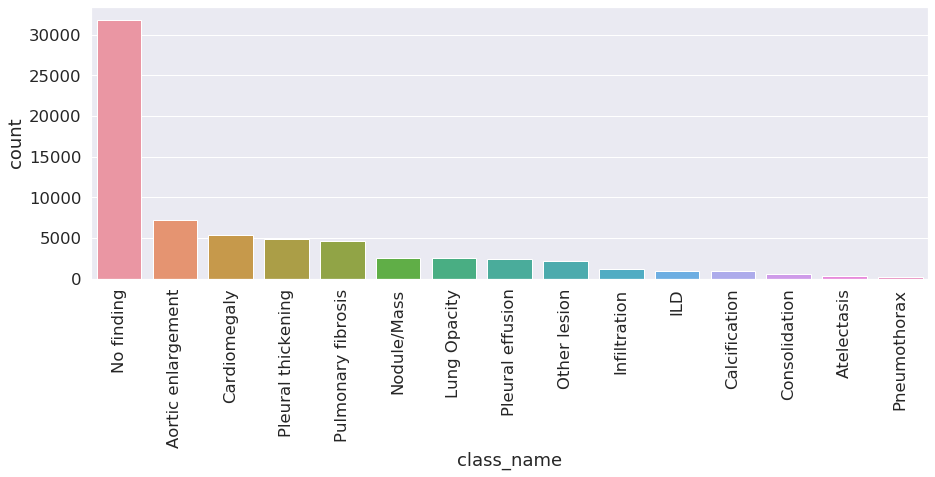

In [5]:
#exploratory analysis
#display the distribution of findings
path = "./"
image_path = "./train/"
train_csv = path + "train.csv"
train_meta_cvs = path + "train_meta.csv" #record dim info of original dicom
train_merged_cvs = path + "train_merged.csv"

#combine the meta info in train.csv and train_meta.csv
#merged_pd = mergeData(train_csv,train_meta_cvs,verbose=False)
#merged_pd.to_csv(train_merged_cvs,index=None)

#load from train_merged.csv and display distributin
merged_pd = pd.read_csv(train_merged_cvs)
dispDist(merged_pd)

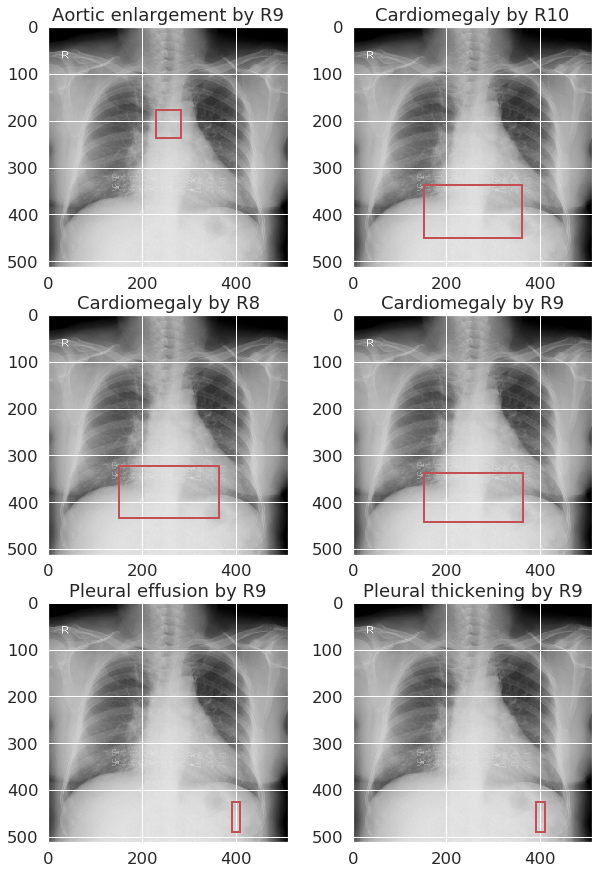

In [7]:
#exploratory analysis
#display the bounding box of an image
filename = "9a5094b2563a1ef3ff50dc5c7ff71345"
img_meta_info = merged_pd[merged_pd["image_id"].isin([filename])]
img_meta_info = img_meta_info.sort_values(by=['class_id','rad_id'])
disp_xray_diagnosis("./" + filename + ".png", img_meta_info)

In [8]:
#1. filter rare samples and unreliable diagnosis
"""
train_set1: class_id=0,10606,;class_id=1,3821;total,14427 
train_set2: class_id=0,2347;class_id=3,1818;class_id=11,1252;class_id=13,1141;total=3821
"""
#regenerate and store into train_set1.csv and train_set2.csv
#train_set1, train_set2 = genSet1andSet2(merged_pd, set1= path+"/train_set1.csv", set2= path+"/train_set2.csv", shuffle_flag = True, persist=True)

#load from train_set1.csv and train_set2.csv
train_set1 = pd.read_csv(path + "train_set1.csv")
train_set2 = pd.read_csv(path + "train_set2.csv")
print(train_set1.head())
print(train_set2.head())

                           image_id  class_id
0  000434271f63a053c4128a0ba6352c7f         0
1  00053190460d56c53cc3e57321387478         0
2  0006e0a85696f6bb578e84fafa9a5607         0
3  000ae00eb3942d27e0b97903dd563a6e         0
4  00176f7e1b1cb835123f95960b9a9efd         0
                           image_id  0  3  11  13
0  0007d316f756b3fa0baea2ff514ce945  1  0   1   1
1  000d68e42b71d3eac10ccc077aba07c1  0  0   1   0
2  00150343289f317a0ad5629d5b7d9ef9  1  0   1   1
3  001d127bad87592efe45a5c7678f8b8d  0  0   0   1
4  0046f681f078851293c4e710c4466058  0  0   1   1


# Simple binary classifier

In [106]:
"""
import shutil
train_b = pd.read_csv(path + "binary_train.csv")
test_b = pd.read_csv(path + "binary_test.csv")

for index,row in train_b.iterrows():
    src = "./train/" + row[0] + ".png"
    dst = "./train2/" + row[0] + ".png"
    shutil.copyfile(src,dst)
    
for index,row in test_b.iterrows():
    src = "./train/" + row[0] + ".png"
    dst = "./train2/" + row[0] + ".png"
    shutil.copyfile(src,dst)
"""

'\nimport shutil\ntrain_b = pd.read_csv(path + "binary_train.csv")\ntest_b = pd.read_csv(path + "binary_test.csv")\n\nfor index,row in train_b.iterrows():\n    src = "./train/" + row[0] + ".png"\n    dst = "./train2/" + row[0] + ".png"\n    shutil.copyfile(src,dst)\n    \nfor index,row in test_b.iterrows():\n    src = "./train/" + row[0] + ".png"\n    dst = "./train2/" + row[0] + ".png"\n    shutil.copyfile(src,dst)\n'

/root/miniconda3/envs/myconda/lib/python3.7/site-packages/keras_applications/resnet50.py:265: UserWarning: The output shape of `ResNet50(include_top=False)` has been changed since Keras 2.2.0.
  warnings.warn('The output shape of `ResNet50(include_top=False)` '


Epoch 1/20
128/128 [==============================] - 39s 302ms/step - loss: 1.0133 - accuracy: 0.4453
Epoch 2/20
128/128 [==============================] - 7s 56ms/step - loss: 0.7743 - accuracy: 0.5234
Epoch 3/20
128/128 [==============================] - 7s 56ms/step - loss: 0.7619 - accuracy: 0.5781
Epoch 4/20
128/128 [==============================] - 7s 56ms/step - loss: 0.6812 - accuracy: 0.5781
Epoch 5/20
128/128 [==============================] - 7s 56ms/step - loss: 0.5711 - accuracy: 0.7031
Epoch 6/20
128/128 [==============================] - 7s 56ms/step - loss: 0.5403 - accuracy: 0.7109
Epoch 7/20
128/128 [==============================] - 7s 56ms/step - loss: 0.5959 - accuracy: 0.7031
Epoch 8/20
128/128 [==============================] - 7s 56ms/step - loss: 0.6130 - accuracy: 0.7188
Epoch 9/20
128/128 [==============================] - 7s 56ms/step - loss: 0.5172 - accuracy: 0.7266
Epoch 10/20
128/128 [==============================] - 7s 56ms/step - loss: 0.4109 - accu

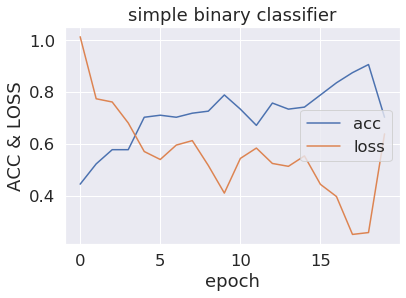

In [18]:
# binary classifier 1
# get 128 images for training, 64 positive cases and 64 negative cases
train_b = pd.read_csv(path + "binary_train.csv")
X_train, Y_train = getData(train_b, image_path=image_path, shuffle_flag=False, Y_range=[1], verbose=False)
# create a new binary classifier model
b1model = customizeResNet(input_shape=(512,512,1),output_shape=1,model_path=None,include_top=False, net_type='binary')
training = b1model.fit(X_train, Y_train, epochs=20, batch_size=8)
# plot ACC and loss of training
f = plt.gcf()
plt.plot(training.history['accuracy'])
plt.plot(training.history['loss'])
plt.title('simple binary classifier')
plt.xlabel('epoch')
plt.ylabel('ACC & LOSS')
plt.legend(['acc', 'loss'], loc='center right')
plt.show()
f.savefig('./simple_binary_classifier.png',bbox_inches = 'tight')

In [19]:
# evaluation of binary classifier 1
test_b = pd.read_csv(path + "binary_test.csv")
X_test, Y_test = getData(test_b, image_path=image_path, shuffle_flag=False, X_shape=(512,512,1), Y_range=[1], verbose=False)

Y_test_pred = np.round(b1model.predict(X_test))
m_recall = tf.keras.metrics.Recall()
m_recall.update_state(Y_test.values,Y_test_pred)
print('recall for simple binary classifier: ' + str(m_recall.result().numpy()))

m_accuracy = tf.keras.metrics.Accuracy()
m_accuracy.update_state(Y_test.values,Y_test_pred)
print('accuracy for simple binary classifier: ' + str(m_accuracy.result().numpy()))

recall for simple binary classifier: 0.015625
accuracy for simple binary classifier: 0.5078125


# Second binary classifier

/root/miniconda3/envs/myconda/lib/python3.7/site-packages/keras_applications/resnet50.py:265: UserWarning: The output shape of `ResNet50(include_top=False)` has been changed since Keras 2.2.0.
  warnings.warn('The output shape of `ResNet50(include_top=False)` '


Epoch 1/20
128/128 [==============================] - 32s 252ms/step - loss: 20.3530 - accuracy: 0.4922
Epoch 2/20
128/128 [==============================] - 7s 55ms/step - loss: 13.2694 - accuracy: 0.5234
Epoch 3/20
128/128 [==============================] - 7s 56ms/step - loss: 9.7864 - accuracy: 0.5234
Epoch 4/20
128/128 [==============================] - 7s 55ms/step - loss: 7.4124 - accuracy: 0.5469
Epoch 5/20
128/128 [==============================] - 7s 55ms/step - loss: 5.8750 - accuracy: 0.5391
Epoch 6/20
128/128 [==============================] - 7s 55ms/step - loss: 4.5913 - accuracy: 0.6250
Epoch 7/20
128/128 [==============================] - 7s 55ms/step - loss: 3.6673 - accuracy: 0.6562
Epoch 8/20
128/128 [==============================] - 7s 55ms/step - loss: 3.0987 - accuracy: 0.5781
Epoch 9/20
128/128 [==============================] - 7s 55ms/step - loss: 2.5292 - accuracy: 0.6562
Epoch 10/20
128/128 [==============================] - 7s 55ms/step - loss: 2.1809 - ac

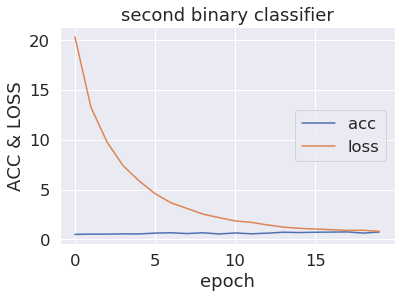

In [14]:
# binary classifier 2
# get 128 images for training, 64 positive cases and 64 negative cases
train_b = pd.read_csv(path + "binary_train.csv")
X_train, Y_train = getData(train_b, image_path=image_path, shuffle_flag=False, Y_range=[1], verbose=False)
# create a new binary classifier model
b2model = customizeResNet(input_shape=(512,512,1),output_shape=1,model_path=None,include_top=False, net_type='binary2')
training = b2model.fit(X_train, Y_train, epochs=20, batch_size=8)
# plot ACC and loss of training
f = plt.gcf()
plt.plot(training.history['accuracy'])
plt.plot(training.history['loss'])
plt.title('second binary classifier')
plt.xlabel('epoch')
plt.ylabel('ACC & LOSS')
plt.legend(['acc', 'loss'], loc='center right')
plt.show()
f.savefig('./second_binary_classifier.png',bbox_inches = 'tight')

In [15]:
# evaluation of binary classifier 2
test_b = pd.read_csv(path + "binary_test.csv")
X_test, Y_test = getData(test_b, image_path=image_path, shuffle_flag=False, X_shape=(512,512,1), Y_range=[1], verbose=False)

Y_test_pred = np.round(b2model.predict(X_test))
m_recall = tf.keras.metrics.Recall()
m_recall.update_state(Y_test.values,Y_test_pred)
print('recall for second binary classifier: ' + str(m_recall.result().numpy()))

m_accuracy = tf.keras.metrics.Accuracy()
m_accuracy.update_state(Y_test.values,Y_test_pred)
print('accuracy for second binary classifier: ' + str(m_accuracy.result().numpy()))

recall for second binary classifier: 0.0
accuracy for second binary classifier: 0.5


# Multi-label classifier

In [104]:
#select 128 abnormal images for multi-label training
"""
import shutil
train_s21 = pd.read_csv(path + "train_s21.csv")
train_m = train_s21.iloc[0:128,:]
test_m = train_s21.iloc[128:256,:]
train_m.to_csv(path+"/multi_label_train.csv",index=None)
test_m.to_csv(path+"/multi_label_test.csv",index=None)

for index,row in train_m.iterrows():
    src = "./train/" + row[0] + ".png"
    dst = "./train2/" + row[0] + ".png"
    shutil.copyfile(src,dst)
    
for index,row in test_m.iterrows():
    src = "./train/" + row[0] + ".png"
    dst = "./train2/" + row[0] + ".png"
    shutil.copyfile(src,dst)
"""

'\nimport shutil\ntrain_s21 = pd.read_csv(path + "train_s21.csv")\ntrain_m = train_s21.iloc[0:128,:]\ntest_m = train_s21.iloc[128:256,:]\ntrain_m.to_csv(path+"/multi_label_train.csv",index=None)\ntest_m.to_csv(path+"/multi_label_test.csv",index=None)\n\nfor index,row in train_m.iterrows():\n    src = "./train/" + row[0] + ".png"\n    dst = "./train2/" + row[0] + ".png"\n    shutil.copyfile(src,dst)\n    \nfor index,row in test_m.iterrows():\n    src = "./train/" + row[0] + ".png"\n    dst = "./train2/" + row[0] + ".png"\n    shutil.copyfile(src,dst)\n'

/root/miniconda3/envs/myconda/lib/python3.7/site-packages/keras_applications/resnet50.py:265: UserWarning: The output shape of `ResNet50(include_top=False)` has been changed since Keras 2.2.0.
  warnings.warn('The output shape of `ResNet50(include_top=False)` '


Epoch 1/20
128/128 [==============================] - 32s 251ms/step - loss: 0.8601 - accuracy: 0.5391
Epoch 2/20
128/128 [==============================] - 7s 55ms/step - loss: 0.7807 - accuracy: 0.5508
Epoch 3/20
128/128 [==============================] - 7s 55ms/step - loss: 0.6606 - accuracy: 0.6172
Epoch 4/20
128/128 [==============================] - 7s 55ms/step - loss: 0.6925 - accuracy: 0.6035
Epoch 5/20
128/128 [==============================] - 7s 55ms/step - loss: 0.6987 - accuracy: 0.5938
Epoch 6/20
128/128 [==============================] - 7s 55ms/step - loss: 0.6672 - accuracy: 0.6094
Epoch 7/20
128/128 [==============================] - 7s 55ms/step - loss: 0.6435 - accuracy: 0.6328
Epoch 8/20
128/128 [==============================] - 7s 55ms/step - loss: 0.6409 - accuracy: 0.6250
Epoch 9/20
128/128 [==============================] - 7s 55ms/step - loss: 0.6462 - accuracy: 0.6270
Epoch 10/20
128/128 [==============================] - 7s 55ms/step - loss: 0.6334 - accu

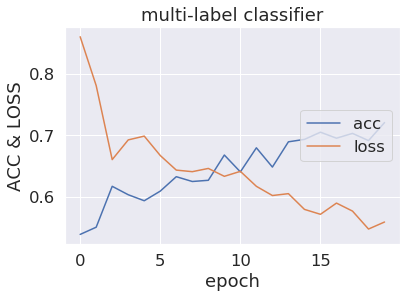

In [16]:
# multi-label classifier
# get 128 images for training, 64 positive cases and 64 negative cases
train_m = pd.read_csv(path + "multi_label_train.csv")
X_train, Y_train = getData(train_m, image_path=image_path, shuffle_flag=False, Y_range=[1,2,3,4], verbose=False)
# create a new binary classifier model
mmodel = customizeResNet(input_shape=(512,512,1),output_shape=4,model_path=None,include_top=False, net_type='multilabel')
training = mmodel.fit(X_train, Y_train, epochs=20, batch_size=8)
# plot ACC and loss of training
f = plt.gcf()
plt.plot(training.history['accuracy'])
plt.plot(training.history['loss'])
plt.title('multi-label classifier')
plt.xlabel('epoch')
plt.ylabel('ACC & LOSS')
plt.legend(['acc', 'loss'], loc='center right')
plt.show()
f.savefig('./multi-label_classifier.png',bbox_inches = 'tight')

In [17]:
# evaluation of multi-label classifier
test_m = pd.read_csv(path + "multi_label_test.csv")
X_test, Y_test = getData(test_m, image_path=image_path, shuffle_flag=False, X_shape=(512,512,1), Y_range=[1,2,3,4], verbose=False)

mmodel.evaluate(X_train, Y_train)

128/128 [==============================] - 4s 32ms/step


[4.595861434936523, 0.408203125]

# end of project code